<a href="https://colab.research.google.com/github/gnomez1208/gnomez1208/blob/main/LDR_3_0_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import files

print("Please select 'output03048 (1).root' from your Ubuntu machine.")
uploaded = files.upload()
#saved onto google colab local file environment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.5/903.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.9/655.9 kB 13.2 MB/s eta 0:00:00
Please select 'output03048 (1).root' from your Ubuntu machine.


Saving output03048 (1).root to output03048 (1).root


In [ ]:
!pip install uproot

NameError: name 'uproot' is not defined

In [ ]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

file_path = "/content/output03048 (1).root"

# =========================================================
# --- FINAL ANALYSIS PARAMETERS ---
# =========================================================

sampling_frequency = 250e6  # 250 MHz

# --- Baseline and Filter Parameters ---

pre_ns = 500  # ns of pre-trigger region for initial noise calculation
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)

bp_lo, bp_hi = 2e6, 35e6  # Bandpass filter for finding peaks
b, a = butter(2, [bp_lo / (sampling_frequency / 2), bp_hi / (sampling_frequency / 2)], btype="band")

# --- Peak Selection and Integration Parameters ---
min_width_ns, max_width_ns = 12, 200
min_width = max(1, int(min_width_ns * 1e-9 * sampling_frequency))
max_width = int(max_width_ns * 1e-9 * sampling_frequency)
prom_sigma = 4  # Prominence threshold in units of noise sigma

int_pre_ns, int_post_ns = 8, 20  # Use a semi-wide window to capture the full charge
int_pre = int(int_pre_ns * 1e-9 * sampling_frequency)
int_post = int(int_post_ns * 1e-9 * sampling_frequency)

refractory_ns = 200  # Pile-up rejection
refractory = int(refractory_ns * 1e-9 * sampling_frequency)


# =========================================================
# --- DEFINED FUNCTIONS ---
# =========================================================

def baseline_stats(x, pre=pre_samp):
    """Robust baseline and noise estimation using median and MAD from pre-trigger."""
    r = x[:pre]
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    sigma = 1.4826 * mad if mad > 0 else np.std(r)
    return med, sigma

def generate_pedestal_samples(waveform_slice, window_size):
    """Slides an integration window across a quiet waveform slice."""
    charges = []
    num_windows = len(waveform_slice) - window_size
    if num_windows <= 0: return charges
    for i in range(num_windows):
        window = waveform_slice[i : i + window_size]
        q = np.trapezoid(window)
        charges.append(-q)
    return charges

def integrate_charge_unfiltered(x_unfiltered, peak_idx):
    """Integrates charge on the final, baseline-corrected waveform."""
    a = max(0, peak_idx - int_pre)
    b = min(len(x_unfiltered), peak_idx + int_post)
    q = np.sum(x_unfiltered[a:b])
    return -q

print('\nFunctions and parameter have been defined.')


Functions and parameter have been defined.


#Check Filtering



In [ ]:
# --- Cell 1: Plot Original vs. Filtered (Interactive) ---
import plotly.express as px

waveform_index_to_plot = 2100
waveform_index_to_plot2 = 810
waveform_index_to_plot3 = 520

# --- Re-create the filter parameters ---
sampling_frequency = 250e6
pre_ns = 400
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)
bp_lo, bp_hi = 1e6, 75e6
lowpass_cutoff_freq = 20e6
b, a = butter(2, lowpass_cutoff_freq / (sampling_frequency/2), btype="low")

# --- Load and process the single waveform ---
with uproot.open(file_path) as file:
    keys = file.keys()
    waveform_np = -file[keys[waveform_index_to_plot]].values().astype(np.float64)

baseline = np.median(waveform_np[:pre_samp])
x0 = waveform_np - baseline
xf = filtfilt(b, a, x0)

# --- Create a DataFrame for Plotly ---
df = pd.DataFrame({
    'Sample': np.arange(len(waveform_np)),
    'Original Waveform': waveform_np,
    # Add baseline back to overlay correctly
    'Filtered Waveform': xf + baseline
})

# --- Create the interactive plot with px.line ---
fig = px.line(
    df,
    x='Sample',
    y=['Original Waveform', 'Filtered Waveform'],
    title=f"Event #{waveform_index_to_plot}: Original vs. Filtered (Interactive)",
    labels={'value': 'ADC Counts', 'variable': 'Trace'}
)

fig.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import uproot
from scipy.signal import butter, filtfilt
import numpy as np

# --- Define the events you want to plot ---
waveform_indices = [2100, 810, 520]

# --- Re-create the filter parameters ---
sampling_frequency = 250e6
lowpass_cutoff_freq = 20e6
b, a = butter(2, lowpass_cutoff_freq / (sampling_frequency / 2), btype="low")
pre_ns = 400
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)

# --- 1. Create a figure with 3 rows of subplots ---
fig = make_subplots(
    rows=len(waveform_indices),
    cols=1,
    subplot_titles=[f"Event #{i}" for i in waveform_indices]
)

# --- 2. Loop through each event, process it, and add it to the figure ---
with uproot.open(file_path) as file:
    keys = file.keys()

    for i, event_index in enumerate(waveform_indices):
        # Load the correct waveform
        waveform_np = -file[keys[event_index]].values().astype(np.float64)

        # Process this specific waveform
        baseline = np.median(waveform_np[:pre_samp])
        x0 = waveform_np - baseline
        xf = filtfilt(b, a, x0)

        # Add the 'Original Waveform' trace to the correct subplot
        # Note: We use go.Scatter for more control with subplots
        fig.add_trace(
            go.Scatter(y=waveform_np, name=f'Original #{event_index}', legendgroup=f'{event_index}'),
            row=i + 1, col=1
        )

        # Add the 'Filtered Waveform' trace
        fig.add_trace(
            go.Scatter(y=xf + baseline, name=f'Filtered #{event_index}', legendgroup=f'{event_index}'),
            row=i + 1, col=1
        )

# --- 3. Update the layout for a clean look ---
fig.update_layout(
    height=800,
    title_text="Waveform Visualization for Multiple Events",
    showlegend=True # Set to True to see a legend
)

# Update all y-axis titles at once
for i in range(len(waveform_indices)):
    fig.update_yaxes(title_text="ADC Counts", row=i+1, col=1)

# --- 4. Show the single figure with all three plots ---
fig.show()

#Check Baseline Subtraction

In [ ]:
# --- Cell 2: Plot Baseline-Subtracted vs. Filtered (Interactive) ---

# --- Create a DataFrame for the processed waveforms ---
df_processed = pd.DataFrame({
    'Sample': np.arange(len(x0)),
    'Baseline-Subtracted (x0)': x0,
    'Filtered (xf)': xf
})

# --- Create the interactive plot ---
fig = px.line(
    df_processed,
    x='Sample',
    y=['Baseline-Subtracted (x0)', 'Filtered (xf)'],
    title=f"Event #{waveform_index_to_plot}: Baseline-Subtracted vs. Filtered (Interactive)",
    labels={'value': 'ADC Counts (relative to baseline)', 'variable': 'Trace'}
)

# Add a horizontal line at y=0 for reference
fig.add_hline(y=0, line_dash="dot", line_color="black")

fig.show()

In [ ]:
# --- Cell 2: Plot Baseline-Subtracted vs. Filtered (Interactive) ---

# --- Create a DataFrame for the processed waveforms ---
df_processed = pd.DataFrame({
    'Sample': np.arange(len(x0)),
    'Baseline-Subtracted (x0)': x0,
    'Filtered (xf)': xf
})

# --- Create the interactive plot ---
fig = px.line(
    df_processed,
    x='Sample',
    y=['Baseline-Subtracted (x0)', 'Filtered (xf)'],
    title=f"Event #{waveform_index_to_plot}: Baseline-Subtracted vs. Filtered (Interactive)",
    labels={'value': 'ADC Counts (relative to baseline)', 'variable': 'Trace'}
)

# Add a horizontal line at y=0 for reference
fig.add_hline(y=0, line_dash="dot", line_color="black")

fig.show()

#Peak Height Analysis

Analyzing 5205 waveforms with a 20 ADC height threshold...
Analysis complete. Found 17499 peaks meeting the criteria.


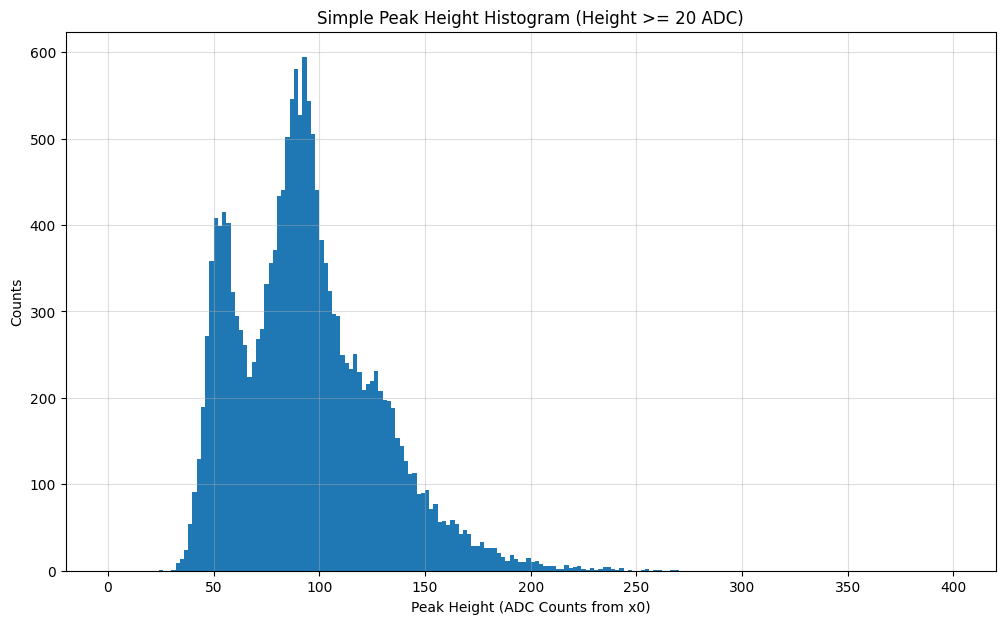

In [ ]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

file_path = "/content/output03048 (1).root"

# =========================================================
# --- FINAL ANALYSIS PARAMETERS ---
# =========================================================

sampling_frequency = 250e6
pre_ns = 500
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)

# Using a low-pass filter
lowpass_cutoff_freq = 75e6
b, a = butter(2, lowpass_cutoff_freq / (sampling_frequency / 2), btype="low")

# Stricter peak selection for cleaner results
min_width_ns, max_width_ns = 12, 200
min_width = max(1, int(min_width_ns * 1e-9 * sampling_frequency))
max_width = int(max_width_ns * 1e-9 * sampling_frequency)
prom_sigma = 6
refractory_ns = 200
refractory = int(refractory_ns * 1e-9 * sampling_frequency)

# =========================================================
# --- GLOBAL ANALYSIS LOOP ---
# =========================================================
spe_heights = []
num_waveforms_to_process = 5205

print(f"Analyzing {waveforms_to_process} waveforms with a 20 ADC height threshold...")

with uproot.open(file_path) as file:
    keys = file.keys()
    waveforms_to_process = min(num_waveforms_to_process, len(keys))

    for i in range(waveforms_to_process):
        waveform_np = file[keys[i]].values().astype(np.float64)

        # Step 1: Baseline subtract
        baseline = np.median(waveform_np[:pre_samp])
        x0 = waveform_np - baseline

        # Step 2: Filter to find peaks reliably
        xf = filtfilt(b, a, x0)

        # Step 3: Find peak locations on the clean, filtered waveform
        noise_sigma = 1.4826 * np.median(np.abs(xf[:pre_samp]))
        if noise_sigma == 0: noise_sigma = 1
        peaks, _ = find_peaks(-xf, prominence=prom_sigma * noise_sigma, width=(min_width, max_width))

        # Pile-up rejection
        if len(peaks) > 1:
            keep = [peaks[0]]
            for p in peaks[1:]:
                if p - keep[-1] >= refractory:
                    keep.append(p)
            peaks = np.array(keep, dtype=int)

        # Step 4: Measure height from x0 and apply the threshold
        if len(peaks) > 0:
            for peak_idx in peaks:
                height = -x0[peak_idx]

                # Only keep peaks with a height of 20 ADC or more.
                if height >= 20:
                    spe_heights.append(height)

print(f"Analysis complete. Found {len(spe_heights)} peaks meeting the criteria.")

# =========================================================
# --- PLOTTING THE SIMPLE HISTOGRAM ---
# =========================================================

# --- Create the simple histogram ---
plt.figure(figsize=(12, 7))
plt.hist(spe_heights, bins=200, range=(0, 400)) # Using a fixed range

plt.title("Simple Peak Height Histogram (Height >= 20 ADC)")
plt.xlabel("Peak Height (ADC Counts from x0)")
plt.ylabel("Counts")
plt.grid(alpha=0.4)
plt.show()

#Finding the Peak Widths


Analyzing 5205 waveforms for peak width...
Analysis complete. Found 17503 peaks.


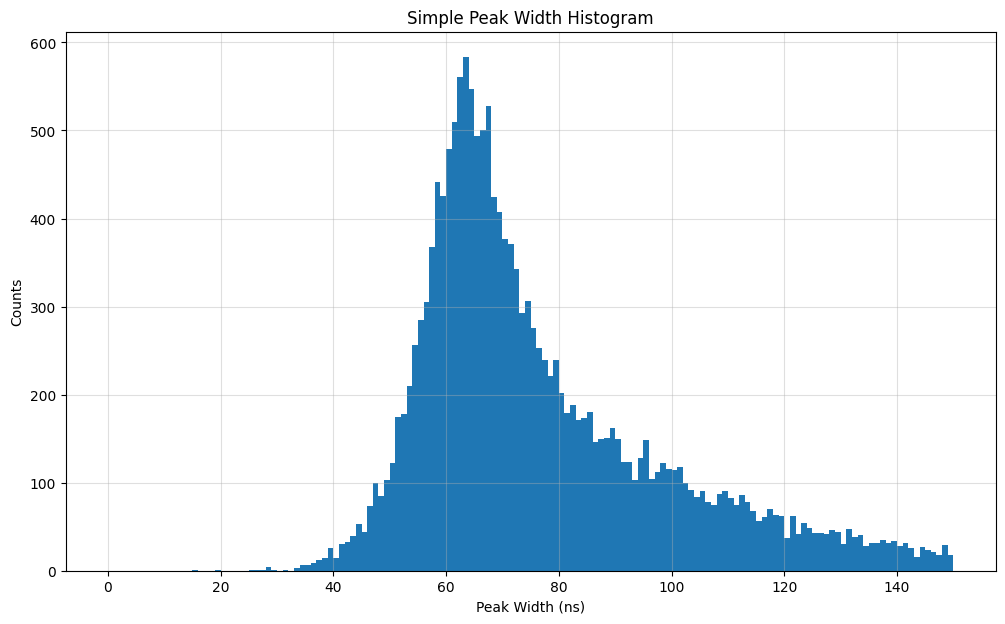

In [ ]:
# This cell will generate a histogram of peak widths

# This list will store the widths of accepted peaks
spe_widths = []

print(f"Analyzing {waveforms_to_process} waveforms for peak width...")

with uproot.open(file_path) as file:
    keys = file.keys()
    waveforms_to_process = min(num_waveforms_to_process, len(keys))

    for i in range(waveforms_to_process):
        waveform_np = file[keys[i]].values().astype(np.float64)

        # Baseline subtraction and filtering
        baseline = np.median(waveform_np[:pre_samp])
        x0 = waveform_np - baseline
        xf = filtfilt(b, a, x0)

        # --- MODIFICATION 1: Capture the 'properties' dictionary from find_peaks ---
        noise_sigma = 1.4826 * np.median(np.abs(xf[:pre_samp]))
        if noise_sigma == 0: noise_sigma = 1
        peaks, properties = find_peaks(-xf, prominence=prom_sigma * noise_sigma, width=(min_width, max_width))

        # --- MODIFICATION 2: Update pile-up rejection to handle properties ---
        if len(peaks) > 1:
            # This list will store the index (0, 1, 2...) of the peaks we want to keep
            keep_indices = [0]
            for j in range(1, len(peaks)):
                # Check the distance between the current peak and the *last kept* peak
                if peaks[j] - peaks[keep_indices[-1]] >= refractory:
                    keep_indices.append(j)

            # Filter both the peak locations and their widths using the indices we found
            final_peaks = peaks[keep_indices]
            final_widths = properties['widths'][keep_indices]
        else:
            final_peaks = peaks
            # Use .get() to safely access 'widths', providing an empty array if it doesn't exist
            final_widths = properties.get('widths', np.array([]))

        # --- MODIFICATION 3: Store the widths ---
        if len(final_peaks) > 0:
            # Add all the found widths for this waveform to our main list
            spe_widths.extend(final_widths)

print(f"Analysis complete. Found {len(spe_widths)} peaks.")

# --- Convert widths from samples to nanoseconds ---
# 1 sample = (1 / sampling_frequency) seconds
# We multiply by 1e9 to get nanoseconds
spe_widths_ns = np.array(spe_widths) * (1 / sampling_frequency) * 1e9

# --- Create the simple histogram of peak widths ---
plt.figure(figsize=(12, 7))
plt.hist(spe_widths_ns, bins=150, range=(0, 150))

plt.title("Simple Peak Width Histogram")
plt.xlabel("Peak Width (ns)")
plt.ylabel("Counts")
plt.grid(alpha=0.4)
plt.show()

#Creating the 2D Histogram for our 1 PE Template w/height and width

Analyzing waveforms to build 2D histogram...
Analysis complete. Found 17499 valid peaks.


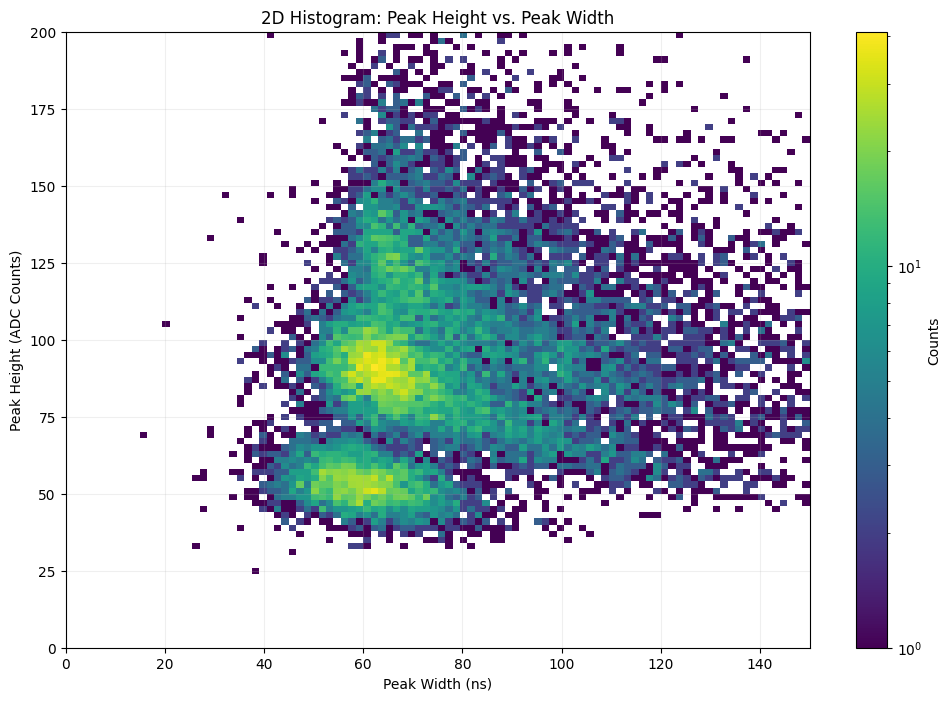

In [ ]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm # Used for better color scaling

file_path = "/content/output03048 (1).root"

# =========================================================
# --- ANALYSIS PARAMETERS ---
# =========================================================
# (Parameters are the same as your last successful run)
sampling_frequency = 250e6
pre_ns = 500
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)
lowpass_cutoff_freq = 75e6
b, a = butter(2, lowpass_cutoff_freq / (sampling_frequency / 2), btype="low")
min_width_ns, max_width_ns = 12, 200
min_width = max(1, int(min_width_ns * 1e-9 * sampling_frequency))
max_width = int(max_width_ns * 1e-9 * sampling_frequency)
prom_sigma = 6
refractory_ns = 200
refractory = int(refractory_ns * 1e-9 * sampling_frequency)

# =========================================================
# --- GLOBAL ANALYSIS LOOP ---
# =========================================================
# --- We'll now store both properties for each peak ---
peak_heights = []
peak_widths = []
num_waveforms_to_process = 5205

print("Analyzing waveforms to build 2D histogram...")
with uproot.open(file_path) as file:
    keys = file.keys()
    waveforms_to_process = min(num_waveforms_to_process, len(keys))

    for i in range(waveforms_to_process):
        waveform_np = file[keys[i]].values().astype(np.float64)

        baseline = np.median(waveform_np[:pre_samp])
        x0 = waveform_np - baseline
        xf = filtfilt(b, a, x0)

        noise_sigma = 1.4826 * np.median(np.abs(xf[:pre_samp]))
        if noise_sigma == 0: noise_sigma = 1
        peaks, properties = find_peaks(-xf, prominence=prom_sigma * noise_sigma, width=(min_width, max_width))

        if len(peaks) > 1:
            keep_indices = [0]
            for j in range(1, len(peaks)):
                if peaks[j] - peaks[keep_indices[-1]] >= refractory:
                    keep_indices.append(j)
            final_peaks = peaks[keep_indices]
            final_widths = properties['widths'][keep_indices]
        else:
            final_peaks = peaks
            final_widths = properties.get('widths', np.array([]))

        if len(final_peaks) > 0:
            for k, peak_idx in enumerate(final_peaks):
                height = -x0[peak_idx]
                if height >= 20:
                    peak_heights.append(height)
                    # Append the corresponding width
                    peak_widths.append(final_widths[k])

print(f"Analysis complete. Found {len(peak_heights)} valid peaks.")

# --- Convert widths to nanoseconds ---
peak_widths_ns = np.array(peak_widths) * (1 / sampling_frequency) * 1e9

# =========================================================
# --- PLOTTING THE 2D HISTOGRAM ---
# =========================================================
plt.figure(figsize=(12, 8))
plt.hist2d(
    peak_widths_ns,
    peak_heights,
    bins=(100, 100),            # 100 bins for width, 100 for height
    range=[[0, 150], [0, 200]], # Adjust ranges as needed
    norm=LogNorm()              # Use a log scale for color to see faint clusters
)

plt.colorbar(label='Counts')
plt.title("2D Histogram: Peak Height vs. Peak Width")
plt.xlabel("Peak Width (ns)")
plt.ylabel("Peak Height (ADC Counts)")
plt.grid(alpha=0.2)
plt.show()

Original number of peaks: 17499
Number of clean 1 PE peaks after 2D cut: 3019


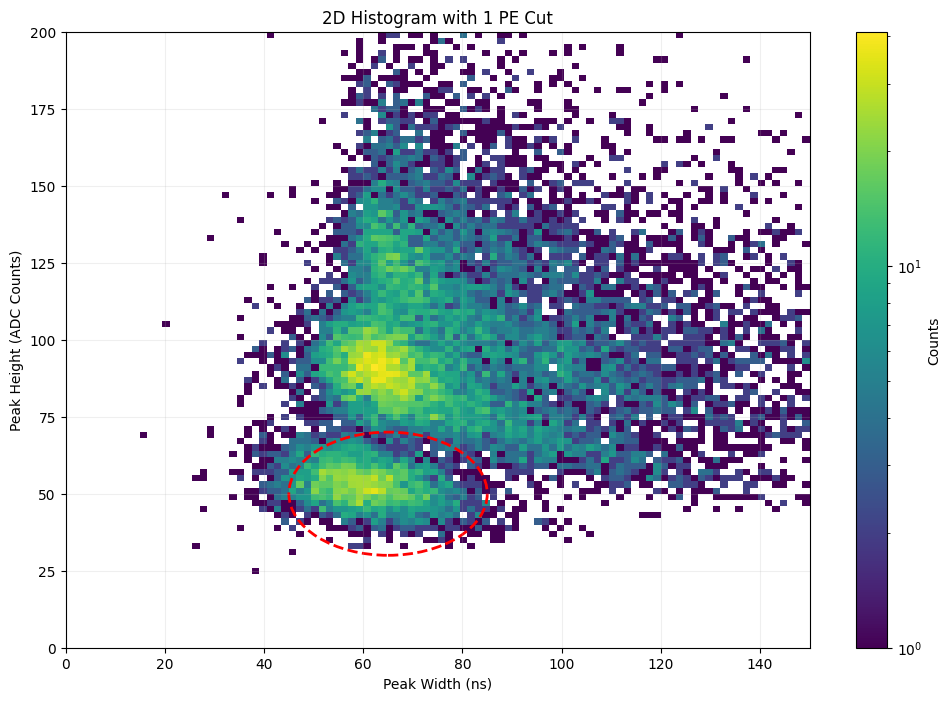

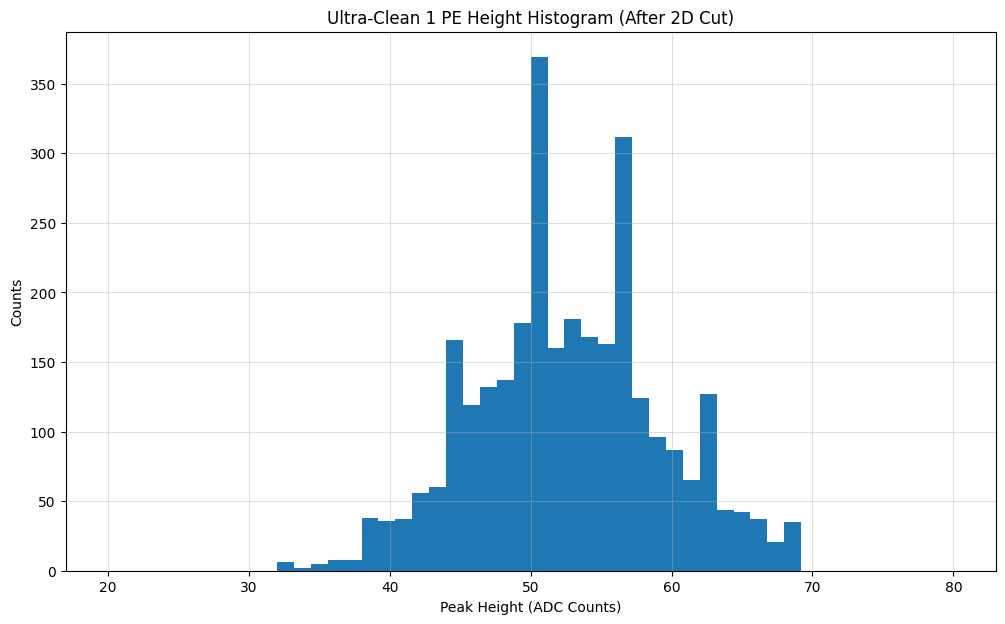

In [ ]:
import matplotlib.patches as patches

# --- Define a circular cut around the 1 PE island ---
# Based on your plot, the center is roughly (width=65, height=50)
center_width = 65
center_height = 50
radius = 20  # The radius of our circular cut in ADC/ns units. Adjust as needed.

# This list will hold the heights of only the events inside our cut
clean_1pe_heights = []

# Loop through all found peaks and apply the cut
for i in range(len(peak_heights)):
    h = peak_heights[i]
    w = peak_widths_ns[i]

    # Calculate distance from the center of the 1 PE cluster
    distance = np.sqrt((w - center_width)**2 + (h - center_height)**2)

    # If the point is inside our circle, keep it
    if distance <= radius:
        clean_1pe_heights.append(h)

print(f"Original number of peaks: {len(peak_heights)}")
print(f"Number of clean 1 PE peaks after 2D cut: {len(clean_1pe_heights)}")

# --- First, let's visualize the cut on the 2D histogram ---
fig, ax = plt.subplots(figsize=(12, 8))
hist = ax.hist2d(
    peak_widths_ns,
    peak_heights,
    bins=(100, 100),
    range=[[0, 150], [0, 200]],
    norm=LogNorm()
)
fig.colorbar(hist[3], ax=ax, label='Counts')

# Add the circle to the plot to show the cut
circle = patches.Circle((center_width, center_height), radius, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
ax.add_patch(circle)

ax.set_title("2D Histogram with 1 PE Cut")
ax.set_xlabel("Peak Width (ns)")
ax.set_ylabel("Peak Height (ADC Counts)")
ax.grid(alpha=0.2)
plt.show()


# --- Now, plot a SUPER CLEAN histogram of only the 1 PE events ---
plt.figure(figsize=(12, 7))
plt.hist(clean_1pe_heights, bins=50, range=(20, 80))
plt.title("Ultra-Clean 1 PE Height Histogram (After 2D Cut)")
plt.xlabel("Peak Height (ADC Counts)")
plt.ylabel("Counts")
plt.grid(alpha=0.4)
plt.show()


--- High-Precision 1 PE Fit Results ---
1 PE Height (Mean): 52.49 ADC
1 PE Resolution (Sigma): 6.67 ADC


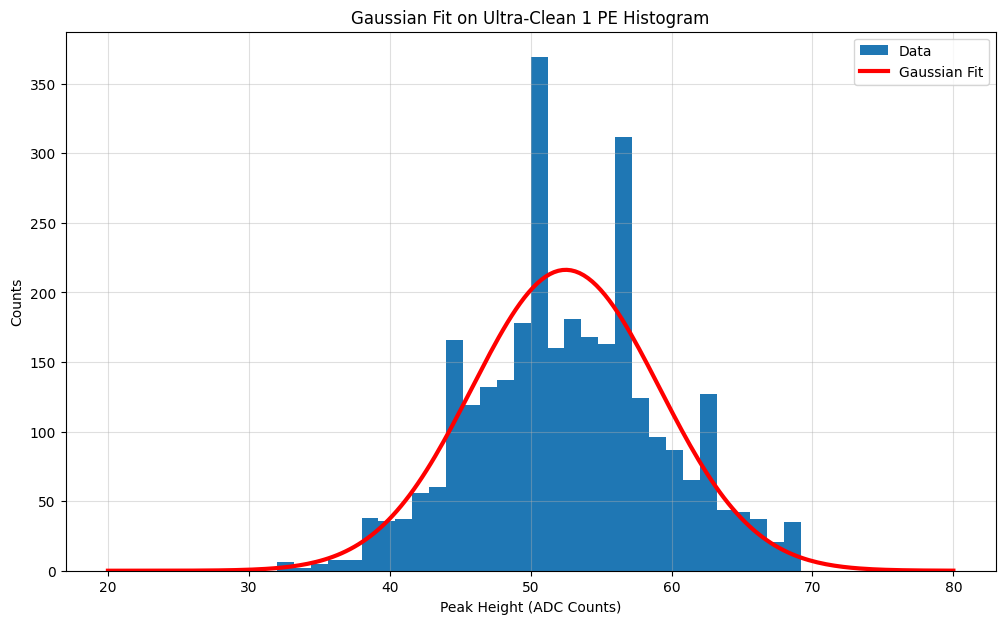

In [ ]:
from scipy.optimize import curve_fit

# This cell assumes 'clean_1pe_heights' exists from the previous step.

# 1. Define the Gaussian function we want to fit
def gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-((x - mean) / sigma)**2 / 2)

# 2. Get the data from the histogram
# We use the same bins and range to be consistent
counts, bin_edges = np.histogram(clean_1pe_heights, bins=50, range=(20, 80))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 3. Perform the fit
# We provide initial guesses (p0) to help the algorithm
initial_guesses = [np.max(counts), 50, 5] # amp, mean, sigma
popt, _ = curve_fit(gaussian, bin_centers, counts, p0=initial_guesses)

# 4. Extract and print the results
fit_amplitude, fit_mean, fit_sigma = popt
print("\n--- High-Precision 1 PE Fit Results ---")
print(f"1 PE Height (Mean): {fit_mean:.2f} ADC")
print(f"1 PE Resolution (Sigma): {fit_sigma:.2f} ADC")

# 5. Plot the histogram with the fit overlaid
plt.figure(figsize=(12, 7))
plt.hist(clean_1pe_heights, bins=50, range=(20, 80), label='Data')

# Create a smooth x-axis for the fit curve
x_fit = np.linspace(bin_edges[0], bin_edges[-1], 200)
plt.plot(x_fit, gaussian(x_fit, *popt), color='red', linewidth=3, label='Gaussian Fit')

plt.title("Gaussian Fit on Ultra-Clean 1 PE Histogram")
plt.xlabel("Peak Height (ADC Counts)")
plt.ylabel("Counts")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

#Create the 1PE Template

Finding and averaging clean 1 PE pulses using a rectangular cut...

Found and averaged 3618 clean 1 PE pulses.
The characteristic 1 PE ADC height is: 53.15


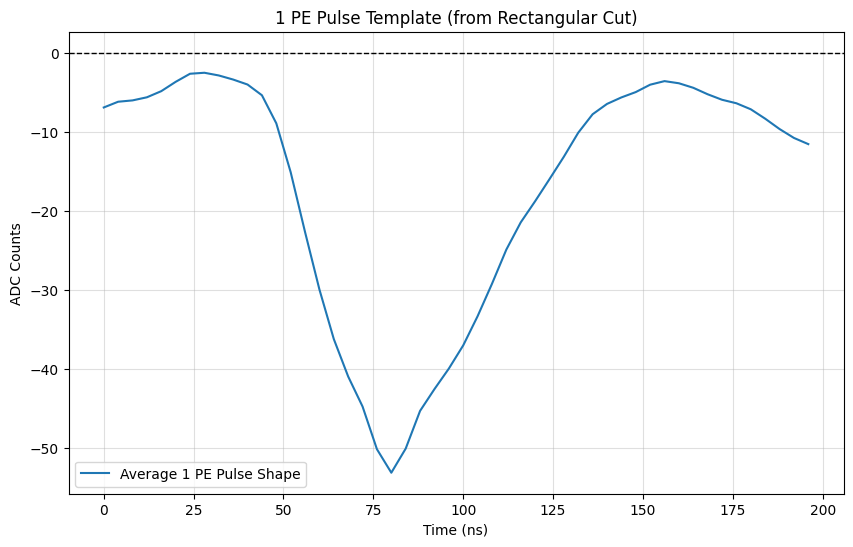

In [ ]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

file_path = "/content/output03048 (1).root"

# =========================================================
# --- ANALYSIS PARAMETERS ---
# =========================================================
sampling_frequency = 250e6
pre_ns = 500
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)
lowpass_cutoff_freq = 75e6
b, a = butter(2, lowpass_cutoff_freq / (sampling_frequency / 2), btype="low")
min_width_ns, max_width_ns = 12, 200
min_width = max(1, int(min_width_ns * 1e-9 * sampling_frequency))
max_width = int(max_width_ns * 1e-9 * sampling_frequency)
prom_sigma = 6
refractory_ns = 200
refractory = int(refractory_ns * 1e-9 * sampling_frequency)

# =========================================================
# --- TEMPLATE CREATION ---
# =========================================================
# This list will store snippets of clean 1 PE waveforms
clean_1pe_snippets = []

# 1. --- Define the precise rectangular cut for 1 PE events ---
height_min, height_max = 30, 70
width_min, width_max = 50, 85

# Define the window to save around each peak (e.g., 20 samples before, 80 after)
pre_peak_samples = 20
post_peak_samples = 30

print("Finding and averaging clean 1 PE pulses using a rectangular cut...")
with uproot.open(file_path) as file:
    keys = file.keys()
    num_waveforms_to_process = 5205
    waveforms_to_process = min(num_waveforms_to_process, len(keys))

    # 2. --- Loop through all waveforms to find clean pulses ---
    for i in range(waveforms_to_process):
        waveform_np = file[keys[i]].values().astype(np.float64)
        baseline = np.median(waveform_np[:pre_samp])
        x0 = waveform_np - baseline
        xf = filtfilt(b, a, x0)

        peaks, properties = find_peaks(-xf, prominence=prom_sigma*np.median(np.abs(xf[:pre_samp]))*1.4826, width=(min_width, max_width))

        if len(peaks) > 0:
            widths_ns = properties['widths'] * (1 / sampling_frequency) * 1e9

            for j, peak_idx in enumerate(peaks):
                height = -x0[peak_idx]
                width = widths_ns[j]

                # Check if the peak is inside our rectangular cut
                if (height_min <= height < height_max) and \
                   (width_min <= width < width_max):

                    # It's a clean 1 PE pulse, save the snippet
                    start = peak_idx - pre_peak_samples
                    end = peak_idx + post_peak_samples

                    if start > 0 and end < len(x0):
                        snippet = x0[start:end]
                        clean_1pe_snippets.append(snippet)

# 3. --- Average all the collected snippets to create the template ---
if len(clean_1pe_snippets) > 1:
    average_pulse = np.mean(clean_1pe_snippets, axis=0)
    average_pulse_height = -average_pulse[pre_peak_samples]

    print(f"\nFound and averaged {len(clean_1pe_snippets)} clean 1 PE pulses.")
    print(f"The characteristic 1 PE ADC height is: {average_pulse_height:.2f}")

    # 4. --- Plot the final template shape ---
    time_axis = np.arange(len(average_pulse)) * (1 / sampling_frequency) * 1e9 # Time in ns
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, average_pulse, label='Average 1 PE Pulse Shape')

    plt.title("1 PE Pulse Template (from Rectangular Cut)")
    plt.xlabel("Time (ns)")
    plt.ylabel("ADC Counts")
    plt.grid(alpha=0.4)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.legend()
    plt.show()

else:
    print("Could not find enough clean 1 PE pulses to create a template.")

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Check if the template from the previous step exists
if 'average_pulse' not in locals():
    print("Please run the template generation cell first!")
else:
    # --- Use the exact 1 PE height from your template ---
    one_pe_height = 53.16
    flipped_template = -average_pulse

    # --- Pick a waveform to display ---
    event_to_plot = 2100

    with uproot.open(file_path) as file:
        keys = file.keys()
        waveform_np = file[keys[event_to_plot]].values().astype(np.float64)

    # Process the waveform to get original and flipped versions
    baseline = np.median(waveform_np[:pre_samp])
    x0 = waveform_np - baseline
    flipped_x0 = -x0

    # --- Create the interactive figure ---
    fig = go.Figure()

    # Add the baseline-subtracted trace (x0) as a reference
    fig.add_trace(go.Scatter(
        y=x0,
        mode='lines',
        name='Baseline-Subtracted (x0)',
        line=dict(color='lightgrey')
    ))

    # Add the flipped waveform trace
    fig.add_trace(go.Scatter(
        y=flipped_x0,
        mode='lines',
        name=f'Flipped Waveform (Event #{event_to_plot})',
        line=dict(color='royalblue')
    ))

    # Add the horizontal 1 PE height line at your precise value
    fig.add_hline(
        y=one_pe_height,
        line_dash="dash",
        line_color="limegreen",
        annotation_text=f'1 PE Height ({one_pe_height:.2f} ADC)',
        annotation_position="bottom right"
    )

    # Find peaks to know where to overlay the template
    xf = filtfilt(b, a, x0)
    peaks, _ = find_peaks(-xf, prominence=prom_sigma * np.median(np.abs(xf[:pre_samp]))*1.4826, width=(min_width, max_width))

    if len(peaks) > 0:
        template_axis = np.arange(len(flipped_template))
        # Overlay the template on the first couple of peaks
        for i, peak_idx in enumerate(peaks[:2]):
            shifted_axis = template_axis + (peak_idx - pre_peak_samples)
            fig.add_trace(go.Scatter(
                x=shifted_axis,
                y=flipped_template,
                mode='lines',
                name='1 PE Template Shape' if i == 0 else None,
                showlegend= (i == 0),
                line=dict(color='red', width=2, dash='dot')
            ))

    # Update the layout for a final polished look
    fig.update_layout(
        title="Final Visualization: 1 PE Template and Height",
        xaxis_title="Sample Number",
        yaxis_title="ADC Counts",
        yaxis_range=[-150, 150]
    )

    fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# This cell assumes 'average_pulse' and 'fit_mean' exist from the previous cells.

if 'average_pulse' not in locals() or 'fit_mean' not in locals():
    print("Please run the previous cells to generate the template and perform the fit first!")
else:
    # --- Prepare the template and the new high-precision height ---
    flipped_template = -average_pulse
    one_pe_fit_height = fit_mean # Use the more accurate value from the fit

    # --- Pick a waveform to display ---
    event_to_plot = 2100

    with uproot.open(file_path) as file:
        keys = file.keys()
        waveform_np = file[keys[event_to_plot]].values().astype(np.float64)

    # Process the waveform
    baseline = np.median(waveform_np[:pre_samp])
    x0 = waveform_np - baseline
    flipped_x0 = -x0

    # --- Create the interactive figure ---
    fig = go.Figure()

    # Add the baseline-subtracted trace (x0)
    fig.add_trace(go.Scatter(
        y=x0,
        mode='lines',
        name='Baseline-Subtracted (x0)',
        line=dict(color='lightgrey')
    ))

    # Add the flipped waveform trace
    fig.add_trace(go.Scatter(
        y=flipped_x0,
        mode='lines',
        name=f'Flipped Waveform (Event #{event_to_plot})',
        line=dict(color='royalblue')
    ))

    # --- Add the horizontal line using the PRECISE fit_mean value ---
    fig.add_hline(
        y=one_pe_fit_height,
        line_dash="dash",
        line_color="limegreen",
        annotation_text=f'1 PE Mean Height ({one_pe_fit_height:.2f} ADC)',
        annotation_position="bottom right"
    )

    # Find peaks and overlay the template shape for visual comparison
    xf = filtfilt(b, a, x0)
    peaks, _ = find_peaks(-xf, prominence=prom_sigma * noise_sigma, width=(min_width, max_width))

    if len(peaks) > 0:
        template_axis = np.arange(len(flipped_template))
        for i, peak_idx in enumerate(peaks[:3]):
            shifted_axis = template_axis + (peak_idx - pre_peak_samples)
            fig.add_trace(go.Scatter(
                x=shifted_axis,
                y=flipped_template,
                mode='lines',
                name='Average 1 PE Template' if i == 0 else None,
                showlegend= (i == 0),
                line=dict(color='red', width=2)
            ))

    # Update the layout for a final look
    fig.update_layout(
        title="Final Visualization: 1 PE Template and Fitted Threshold",
        xaxis_title="Sample Number",
        yaxis_title="ADC Counts",
        yaxis_range=[-150, 150]
    )

    fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# This cell assumes 'average_pulse', 'average_pulse_height', and other parameters exist.

if 'average_pulse' not in locals():
    print("Please run the template generation cell first!")
else:
    # --- Define all the event numbers you want to plot ---
    waveform_indices_to_plot = [2100, 810, 520, 100, 2505, 3100] # Add any 6 indices you like

    # Prepare the template and height data
    flipped_template = -average_pulse
    one_pe_height = average_pulse_height

    # --- 1. Create a figure with a subplot for each event ---
    fig = make_subplots(
        rows=len(waveform_indices_to_plot),
        cols=1,
        subplot_titles=[f"Event #{i}" for i in waveform_indices_to_plot]
    )

    # --- 2. Loop through each event and build its plot ---
    with uproot.open(file_path) as file:
        keys = file.keys()

        for i, event_index in enumerate(waveform_indices_to_plot):
            # The current row in the subplot grid (starts at 1)
            current_row = i + 1

            # Load and process the waveform
            waveform_np = file[keys[event_index]].values().astype(np.float64)
            baseline = np.median(waveform_np[:pre_samp])
            x0 = waveform_np - baseline
            flipped_x0 = -x0

            # --- Add the traces for this subplot ---
            # Add the baseline-subtracted trace (x0)
            fig.add_trace(go.Scatter(
                y=x0, mode='lines', name='Baseline-Subtracted (x0)',
                legendgroup='x0', showlegend=(i==0), # Show legend only for the first plot
                line=dict(color='lightgrey')
            ), row=current_row, col=1)

            # Add the flipped waveform trace
            fig.add_trace(go.Scatter(
                y=flipped_x0, mode='lines', name='Flipped Waveform',
                legendgroup='flipped', showlegend=(i==0),
                line=dict(color='royalblue')
            ), row=current_row, col=1)

            # --- Add the horizontal line using add_shape for subplots ---
            fig.add_shape(
                type="line", x0=0, x1=1, y0=one_pe_height, y1=one_pe_height,
                xref="paper", yref=f"y{current_row}", # Crucial part for subplots
                line=dict(color="limegreen", width=2, dash="dash")
            )

            # --- Overlay the template on the peaks ---
            xf = filtfilt(b, a, x0)
            peaks, _ = find_peaks(-xf, prominence=prom_sigma * noise_sigma, width=(min_width, max_width))
            if len(peaks) > 0:
                template_axis = np.arange(len(flipped_template))
                for j, peak_idx in enumerate(peaks[:3]):
                    shifted_axis = template_axis + (peak_idx - pre_peak_samples)
                    fig.add_trace(go.Scatter(
                        x=shifted_axis, y=flipped_template, mode='lines',
                        name='1 PE Template', legendgroup='template', showlegend=(i==0 and j==0),
                        line=dict(color='red', width=2)
                    ), row=current_row, col=1)

    # --- 3. Update the final layout ---
    fig.update_layout(
        height=2400, # Make the figure taller to accommodate all plots
        title_text="Waveform Visualization for Multiple Events"
    )

    # Update all y-axis titles
    fig.update_yaxes(title_text="ADC Counts", range=[-150, 150])

    fig.show()

#Template for 1-3PE Pulses

Finding and sorting clean 1, 2, and 3 PE pulses...

--- Characteristic PE Heights ---
1 PE Height: 53.15 ADC (from 3596 pulses)
2 PE Height: 92.72 ADC (from 6316 pulses)
3 PE Height: 137.59 ADC (from 2616 pulses)


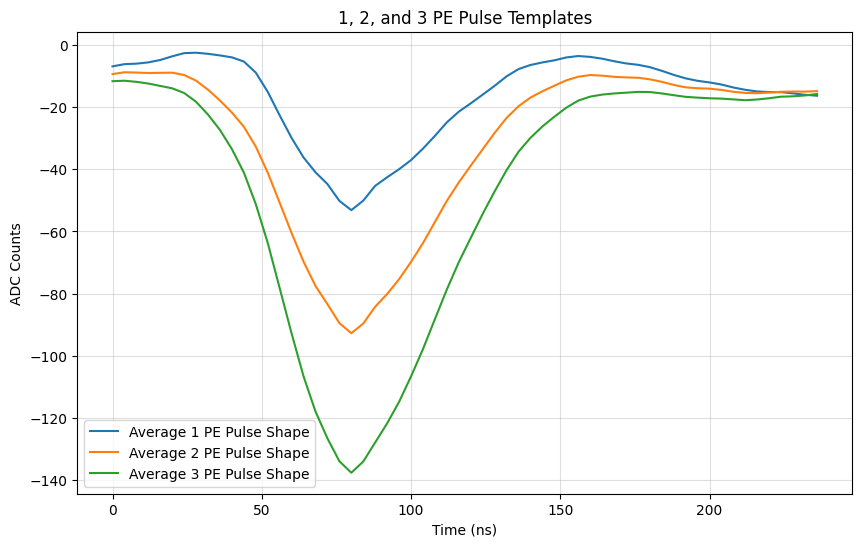

In [ ]:
import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

# =========================================================
# --- ANALYSIS PARAMETERS ---
# =========================================================
# (Parameters are the same as your last successful run)
sampling_frequency = 250e6
pre_ns = 500
pre_samp = int(pre_ns * 1e-9 * sampling_frequency)
lowpass_cutoff_freq = 75e6
b, a = butter(2, lowpass_cutoff_freq / (sampling_frequency / 2), btype="low")
min_width_ns, max_width_ns = 12, 200
min_width = max(1, int(min_width_ns * 1e-9 * sampling_frequency))
max_width = int(max_width_ns * 1e-9 * sampling_frequency)
prom_sigma = 6
refractory_ns = 200
refractory = int(refractory_ns * 1e-9 * sampling_frequency)

# =========================================================
# --- TEMPLATE CREATION FOR 1, 2, & 3 PE ---
# =========================================================
# --- 1. Define separate rectangular cuts for each PE level ---
# (Based on the 2D histogram)
pe_cuts = {
    "1 PE": {"height": (30, 70), "width": (50, 85)},
    "2 PE": {"height": (70, 120), "width": (60, 95)},
    "3 PE": {"height": (120, 170), "width": (60, 105)}
}

# Create separate lists for each category's snippets
pe_snippets = {"1 PE": [], "2 PE": [], "3 PE": []}

# Define the window to save around each peak
pre_peak_samples = 20
post_peak_samples = 40 # Using the shorter tail

print("Finding and sorting clean 1, 2, and 3 PE pulses...")
with uproot.open(file_path) as file:
    keys = file.keys()
    num_waveforms_to_process = 5205
    waveforms_to_process = min(num_waveforms_to_process, len(keys))

    # 2. --- Loop through waveforms to find and classify pulses ---
    for i in range(waveforms_to_process):
        waveform_np = file[keys[i]].values().astype(np.float64)
        baseline = np.median(waveform_np[:pre_samp])
        x0 = waveform_np - baseline
        xf = filtfilt(b, a, x0)

        peaks, properties = find_peaks(-xf, prominence=prom_sigma*np.median(np.abs(xf[:pre_samp]))*1.4826, width=(min_width, max_width))

        if len(peaks) > 0:
            widths_ns = properties['widths'] * (1 / sampling_frequency) * 1e9

            for j, peak_idx in enumerate(peaks):
                height = -x0[peak_idx]
                width = widths_ns[j]

                # Check which rectangular cut the peak falls into
                for name, cut in pe_cuts.items():
                    if (cut["height"][0] <= height < cut["height"][1]) and \
                       (cut["width"][0] <= width < cut["width"][1]):

                        # It's a clean pulse, save the snippet to the correct list
                        start = peak_idx - pre_peak_samples
                        end = peak_idx + post_peak_samples
                        if start > 0 and end < len(x0):
                            pe_snippets[name].append(x0[start:end])
                        break # Stop checking once classified

# 3. --- Average the snippets and get the results for each category ---
pe_templates = {}
pe_heights = {}

print("\n--- Characteristic PE Heights ---")
for name, snippets in pe_snippets.items():
    if len(snippets) > 1:
        average_pulse = np.mean(snippets, axis=0)
        average_height = -average_pulse[pre_peak_samples]
        pe_templates[name] = average_pulse
        pe_heights[name] = average_height
        print(f"{name} Height: {average_height:.2f} ADC (from {len(snippets)} pulses)")

# 4. --- Plot the final template shapes together ---
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(average_pulse)) * (1 / sampling_frequency) * 1e9
for name, template in pe_templates.items():
    plt.plot(time_axis, template, label=f'Average {name} Pulse Shape')

plt.title("1, 2, and 3 PE Pulse Templates")
plt.xlabel("Time (ns)")
plt.ylabel("ADC Counts")
plt.grid(alpha=0.4)
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

# --- Pick a waveform with multiple peaks ---
event_to_plot = 2100

with uproot.open(file_path) as file:
    keys = file.keys()
    waveform_np = file[keys[event_to_plot]].values().astype(np.float64)

# Process the waveform
baseline = np.median(waveform_np[:pre_samp])
x0 = waveform_np - baseline
flipped_x0 = -x0

fig = go.Figure()
fig.add_trace(go.Scatter(y=flipped_x0, mode='lines', name=f'Flipped Waveform #{event_to_plot}'))

# --- Add a horizontal line for each PE height ---
colors = {"1 PE": "red", "2 PE": "orange", "3 PE": "green"}
for name, height in pe_heights.items():
    fig.add_hline(y=height, line_dash="dash", line_color=colors[name],
                  annotation_text=f'{name} Height ({height:.2f})')

# --- Find, classify, and overlay templates on peaks ---
xf = filtfilt(b, a, x0)
peaks, properties = find_peaks(-xf, prominence=prom_sigma*np.median(np.abs(xf[:pre_samp]))*1.4826, width=(min_width, max_width))
if len(peaks) > 0:
    widths_ns = properties['widths'] * (1 / sampling_frequency) * 1e9

    for j, peak_idx in enumerate(peaks):
        height = -x0[peak_idx]
        width = widths_ns[j]

        # Check which category this peak belongs to
        for name, cut in pe_cuts.items():
            if (cut["height"][0] <= height < cut["height"][1]) and \
               (cut["width"][0] <= width < cut["width"][1]):

                # It's a classified pulse, overlay the correct template
                template = pe_templates[name]
                template_axis = np.arange(len(template))
                shifted_axis = template_axis + (peak_idx - pre_peak_samples)

                fig.add_trace(go.Scatter(
                    x=shifted_axis, y=-template, mode='lines',
                    name=f'{name} Template', legendgroup=name, showlegend=False,
                    line=dict(color=colors[name], width=3, dash='dot')
                ))
                break

fig.update_layout(
    title="Multi-PE Template Visualization",
    xaxis_title="Sample Number", yaxis_title="ADC Counts", yaxis_range=[0, 200]
)
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# This cell assumes the 'pe_templates', 'pe_heights', 'pe_cuts', and other parameters exist.

if 'pe_templates' not in locals():
    print("Please run the template generation cell first!")
else:
    # --- Define the specific event numbers you want to plot ---
    waveform_indices_to_plot = [2100, 810, 520, 100, 2505, 3100]

    # --- 1. Create a figure with a subplot for each event ---
    fig = make_subplots(
        rows=len(waveform_indices_to_plot),
        cols=1,
        subplot_titles=[f"Event #{i}" for i in waveform_indices_to_plot]
    )

    # --- 2. Loop through each specified event and build its detailed plot ---
    with uproot.open(file_path) as file:
        keys = file.keys()

        for i, event_index in enumerate(waveform_indices_to_plot):
            current_row = i + 1

            # Load and process the waveform
            waveform_np = file[keys[event_index]].values().astype(np.float64)
            baseline = np.median(waveform_np[:pre_samp])
            x0 = waveform_np - baseline
            flipped_x0 = -x0

            # Add the flipped waveform trace to its subplot
            fig.add_trace(go.Scatter(
                y=flipped_x0, mode='lines', name=f'Waveform #{event_index}',
                showlegend=False, line=dict(color='royalblue')
            ), row=current_row, col=1)

            # --- Add all three horizontal lines to this subplot ---
            colors = {"1 PE": "limegreen", "2 PE": "gold", "3 PE": "orange"}
            for name, height in pe_heights.items():
                fig.add_shape(
                    type="line", x0=0, x1=1, y0=height, y1=height,
                    xref="paper", yref=f"y{current_row}",
                    line=dict(color=colors[name], width=2, dash="dash")
                )

            # --- Find, classify, and overlay all peaks in this waveform ---
            xf = filtfilt(b, a, x0)
            peaks, properties = find_peaks(-xf, prominence=prom_sigma*np.median(np.abs(xf[:pre_samp]))*1.4826, width=(min_width, max_width))
            if len(peaks) > 0:
                widths_ns = properties['widths'] * (1 / sampling_frequency) * 1e9

                for j, peak_idx in enumerate(peaks):
                    height = -x0[peak_idx]
                    width = widths_ns[j]

                    # Check which category this peak belongs to
                    for name, cut in pe_cuts.items():
                        if (cut["height"][0] <= height < cut["height"][1]) and \
                           (cut["width"][0] <= width < cut["width"][1]):

                            # It's a classified pulse, overlay the correct template
                            template = pe_templates[name]
                            template_axis = np.arange(len(template))
                            shifted_axis = template_axis + (peak_idx - pre_peak_samples)

                            fig.add_trace(go.Scatter(
                                x=shifted_axis, y=-template, mode='lines',
                                name=f'{name} Template', legendgroup=name,
                                showlegend=(i==0), # Show legend only on the first subplot
                                line=dict(color=colors[name], width=3, dash='dot')
                            ), row=current_row, col=1)
                            break

    # --- 3. Update the final layout ---
    fig.update_layout(
        height=1500, # Adjust height as needed
        title_text="Detailed Analysis of Specific Waveforms"
    )
    fig.update_yaxes(title_text="ADC Counts", range=[0, 200])
    fig.show()

#GMM Fit



--- Final High-Precision PE Levels (from GMM Fit) ---
Pedestal Height (μ₀): 25.49 ± 9.77 ADC
1 PE Height (μ₁):     53.93 ± 8.93 ADC
2 PE Height (μ₂):     90.36 ± 13.89 ADC
3 PE Height (μ₃):     126.61 ± 30.65 ADC


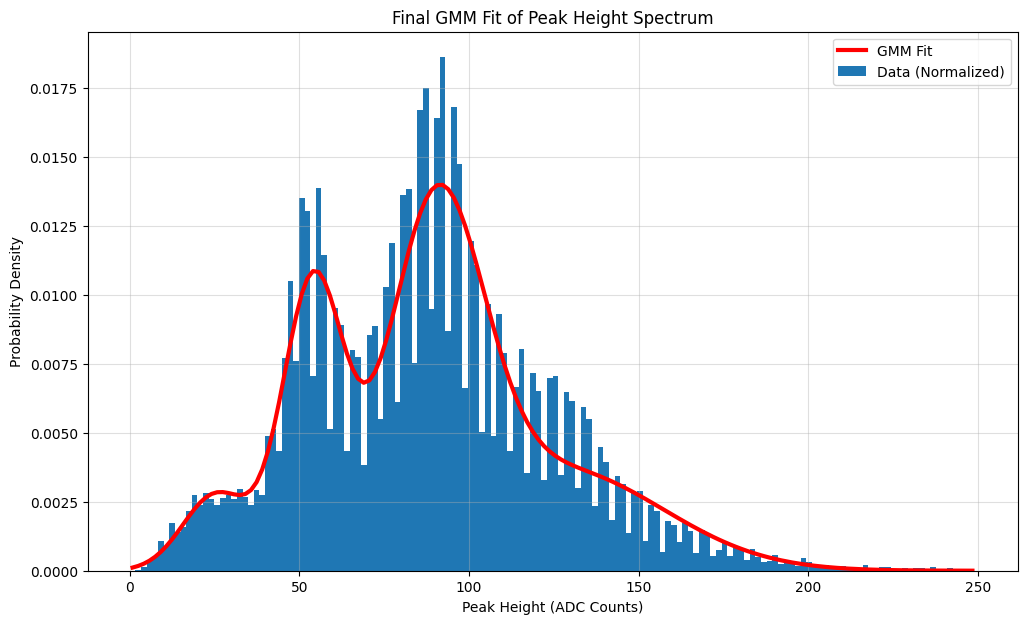

In [ ]:
from scipy.stats import chisquare
import uproot
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# This script assumes 'spe_heights' and 'pedestal_events' lists exist from a previous run.

# 1. --- Combine the clean signal and pedestal data for a full spectrum ---
all_heights = np.concatenate([
    np.array(spe_heights),
    np.array(pedestal_events)
])

# 2. --- Perform the GMM fit on the full histogram ---
gmm = GaussianMixture(n_components=4, random_state=0).fit(all_heights.reshape(-1, 1))

# Extract the means and sigmas
means = gmm.means_.flatten()
covs = gmm.covariances_.flatten()
sort_idx = np.argsort(means)

ped_mu, one_mu, two_mu, three_mu = means[sort_idx]
ped_sigma, one_sigma, two_sigma, three_sigma = np.sqrt(covs[sort_idx])

print("\n--- Final High-Precision PE Levels (from GMM Fit) ---")
print(f"Pedestal Height (μ₀): {ped_mu:.2f} ± {ped_sigma:.2f} ADC")
print(f"1 PE Height (μ₁):     {one_mu:.2f} ± {one_sigma:.2f} ADC")
print(f"2 PE Height (μ₂):     {two_mu:.2f} ± {two_sigma:.2f} ADC")
print(f"3 PE Height (μ₃):     {three_mu:.2f} ± {three_sigma:.2f} ADC")


# 3. --- Plot the Final Result ---
# Get the histogram data to plot against
hist_range = (0, three_mu + 4 * three_sigma)
bins = 150
counts, bin_edges = np.histogram(all_heights, bins=bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create the fit line from the GMM probability density
logprob = gmm.score_samples(bin_centers.reshape(-1, 1))
pdf = np.exp(logprob)

plt.figure(figsize=(12, 7))

# Plot the density histogram
bin_width = bin_edges[1] - bin_edges[0]
plt.bar(bin_centers, counts, width=bin_width, label='Data (Normalized)')

# Plot the GMM fit's probability density function
plt.plot(bin_centers, pdf, color='red', linewidth=3, label='GMM Fit')

plt.title("Final GMM Fit of Peak Height Spectrum")
plt.xlabel("Peak Height (ADC Counts)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

#Pedestal Heights

In [ ]:
# ===============================================
# PREP DATA FOR HEIGHT ANALYSIS
#===============================================
# Convert lists from the main analysis loop into NumPy arrays
all_heights_np = np.array(all_heights)
pedestal_heights_np = np.array(pedestal_heights)

# Combine signal and pedestal heights into a single dataset
all_heights_combined = np.concatenate([all_heights_np, pedestal_heights_np])

print(f"Prepared a total of {len(all_heights_combined)} height events for fitting.")
print(f"({len(all_heights_np)} signal events and {len(pedestal_heights_np)} pedestal events)")


Prepared a total of 1479 height events for fitting.
(612 signal events and 867 pedestal events)


##**Pulse Height Histogram**